## Assignment Information

| Field | Details |
|-------|---------|
| **Name** | Pros Loung |
| **Course** | AAI-521 Applied Computer Vision for AI |
| **Assignment** | 3.1 - Object Detection and Segmentation |
| **GitHub Repository** | https://github.com/ploung/AAI-521-ComputerVision_Module3.git |

---

### Assignment Overview


In [95]:
# Import necessary libraries
# ! Install tensorflow-datasets if not already installed
# !pip install tensorflow-hub
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import numpy as np
import cv2

In [96]:
# a) Load the oxford_iiit_pet dataset

dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)
train_ds = dataset['train']
test_ds = dataset['test']

# Explore the dataset
print(info) 
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of test samples: {len(test_ds)}")

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='C:\\Users\\Loung\\tensorflow_datasets\\oxford_iiit_pet\\4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'la

Training Dataset Samples:
Displaying 3: images


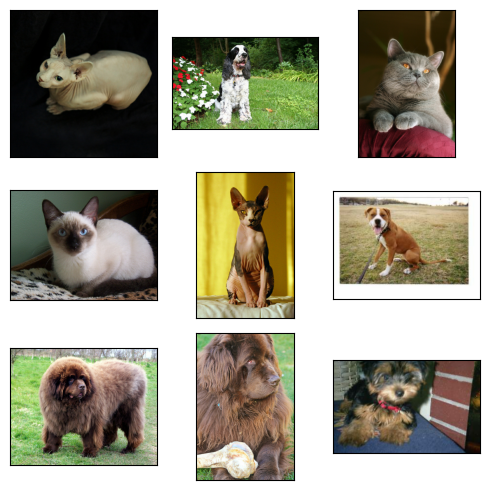

Testing Dataset Samples:
Displaying 3: images


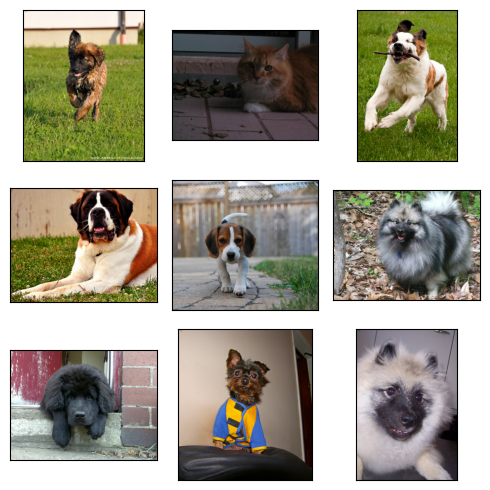

In [97]:
# Visualize some images from the dataset 
ImageLabel = info.features['label'].names

def ShowImage(ImageData, NumImg=2):
    '''Displays the first number of images from the dataset.'''
    print(f'Displaying {NumImg}: images')
    plt.figure(figsize=(5, 5))
    for i in range(NumImg * NumImg):
        plt.subplot(NumImg, NumImg, i + 1)
        plt.xticks([])  
        plt.yticks([])  
        plt.grid(False)
        plt.imshow(ImageData[i], cmap=plt.cm.binary)
        #plt.xlabel([ImageLabel[i]])
    plt.tight_layout()
    plt.show()

train_dataset = dataset['train']
test_dataset = dataset['test']

print("Training Dataset Samples:")
ShowImage([data['image'].numpy().squeeze() for data in train_dataset.take(9)], NumImg=3)

print("Testing Dataset Samples:")
ShowImage([data['image'].numpy().squeeze() for data in test_dataset.take(9)], NumImg=3)

In [98]:
def read_and_preprocess(data):
    input_image = data['image']  
    input_mask = data['segmentation_mask']
    
    # Resize images to 128x128
    input_image = tf.image.resize(input_image, [128, 128])
    input_mask = tf.image.resize(input_mask, [128, 128])
    
    # ! Important: Proper image normalization for display
    #input_image = tf.image.convert_image_dtype(input_image, tf.float32) # [0,1]
    #input_mask -= 1 # {1,2,3} to {0,1,2}
    input_image = tf.cast(input_image, tf.float32) / 255.0  # Normalize to [0,1]
    
    # ? Process mask properly
    input_mask = tf.cast(input_mask, tf.float32)
    input_mask -= 1  # {1,2,3} to {0,1,2}
    
    return input_image, input_mask

In [99]:
train = dataset['train'].map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(read_and_preprocess)

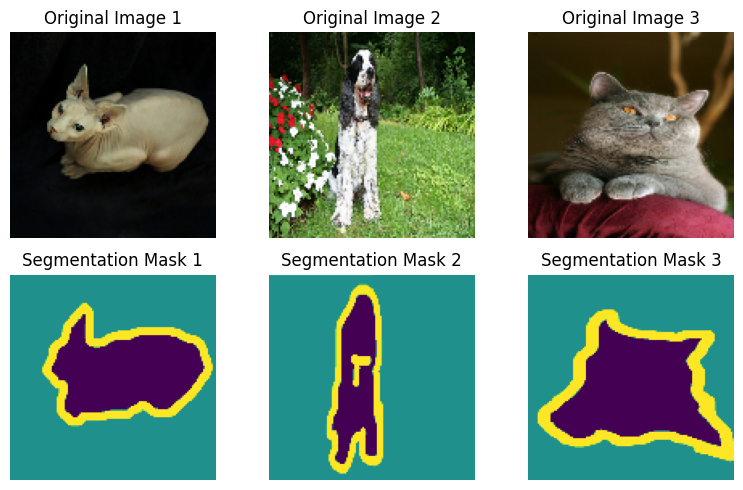

In [100]:
# b) Create the segmentation mask
# Show some images from dataset and their segmented version

images, masks = next(iter(train.batch(3)))

# Create a 2x3 subplot layout: images on top row, masks on bottom row
plt.figure(figsize=(8, 5))

# Display the original images on the top row
for i in range(3):
    plt.subplot(2, 3, i+1)  
    plt.imshow(images[i])
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

# Display the masks on the bottom row
for i in range(3):
    plt.subplot(2, 3, i+4)  
    plt.imshow(masks[i], cmap='viridis')  
    plt.title(f'Segmentation Mask {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

**Part 2- Annotation**

In [102]:
# Install mrcnn if not already installed
#!pip install mrcnn

In [103]:
# Get data from here https://github.com/experiencor/raccoon_dataset
# Uncomment to clone git repo
# !git clone https://github.com/experiencor/raccoon_dataset

In [104]:
# Load dataset and plot some sample images

import os

def load_images(dataset_path='None'):
    """Create method images from the dataset directory"""
    images_path = os.path.join(dataset_path, 'images')
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    images = []
    image_names = []
    
    for image_file in image_files:
        image_path = os.path.join(images_path, image_file)
        
        # Load image using OpenCV
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        images.append(image)
        image_names.append(image_file)
    
    print(f"Loaded {len(images)} images")
    return images, image_names

def plot_images(images, num_images=6):
    """Create method to plot sample images from the dataset"""
    plt.figure(figsize=(8, 5))
    for i in range(num_images):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Image {i + 1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Loaded 200 images


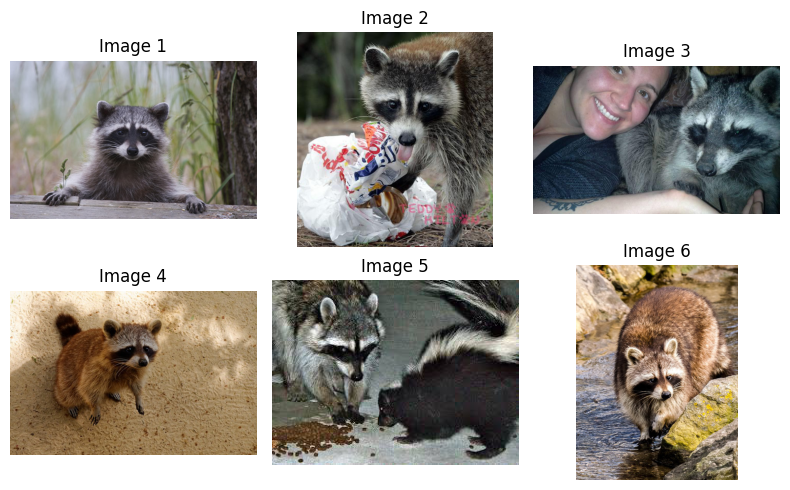

In [105]:
# Load the Raccoon dataset images
images, names = load_images('raccoon_dataset')

# Plot sample images from the Raccoon dataset
plot_images(images, num_images=6)

In [106]:
# !pip install scipy scikit-image
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset

# class that defines and loads the raccoon dataset
class RaccoonDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("raccoon_dataset", 1, "raccoon")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annotations/raccoon-'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[8:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		#path = '/content/raccoon_dataset/annotations/raccoon-'+image_id   #Added by me
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('raccoon'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

# train set
train_set = RaccoonDataset()
train_set.load_dataset('raccoon_dataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = RaccoonDataset()
test_set.load_dataset('raccoon_dataset', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 149
Test: 51


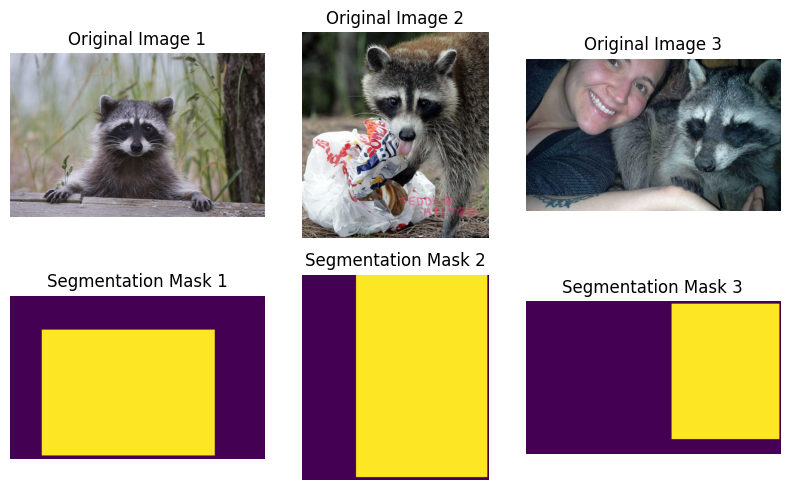

In [107]:
# load an image
# Use the function above to create the image and its mask
image_Mask = RaccoonDataset()
image_Mask.load_dataset('raccoon_dataset', is_train=True)
image_Mask.prepare()


# Display the original images on the top row
plt.figure(figsize=(8, 5))
for i in range(3):
    image, mask = image_Mask.load_image(i), image_Mask.load_mask(i)[0]
    plt.subplot(2, 3, i+1)  
    plt.imshow(image)
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

# Display the masks on the bottom row
    plt.subplot(2, 3, i+4)  
    plt.imshow(mask, cmap='viridis')  
    plt.title(f'Segmentation Mask {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

**Part 3- YOLO**

You can see how YOLO has been improved in the last few versions on COCO: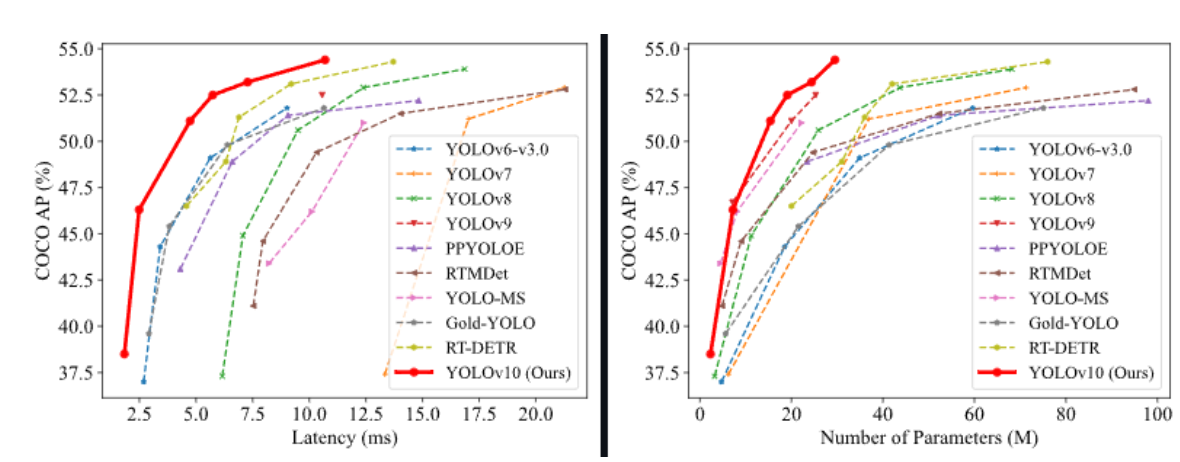

In [108]:
# a- Create annotation
# You can upload the file using ![title](filename.jpeg)
# import image module

face_dataset = load_images('face_dataset')

print(f"Number of images in the dataset: {len(face_dataset)}")


Loaded 21 images
Number of images in the dataset: 2


Number of images in the dataset: 21


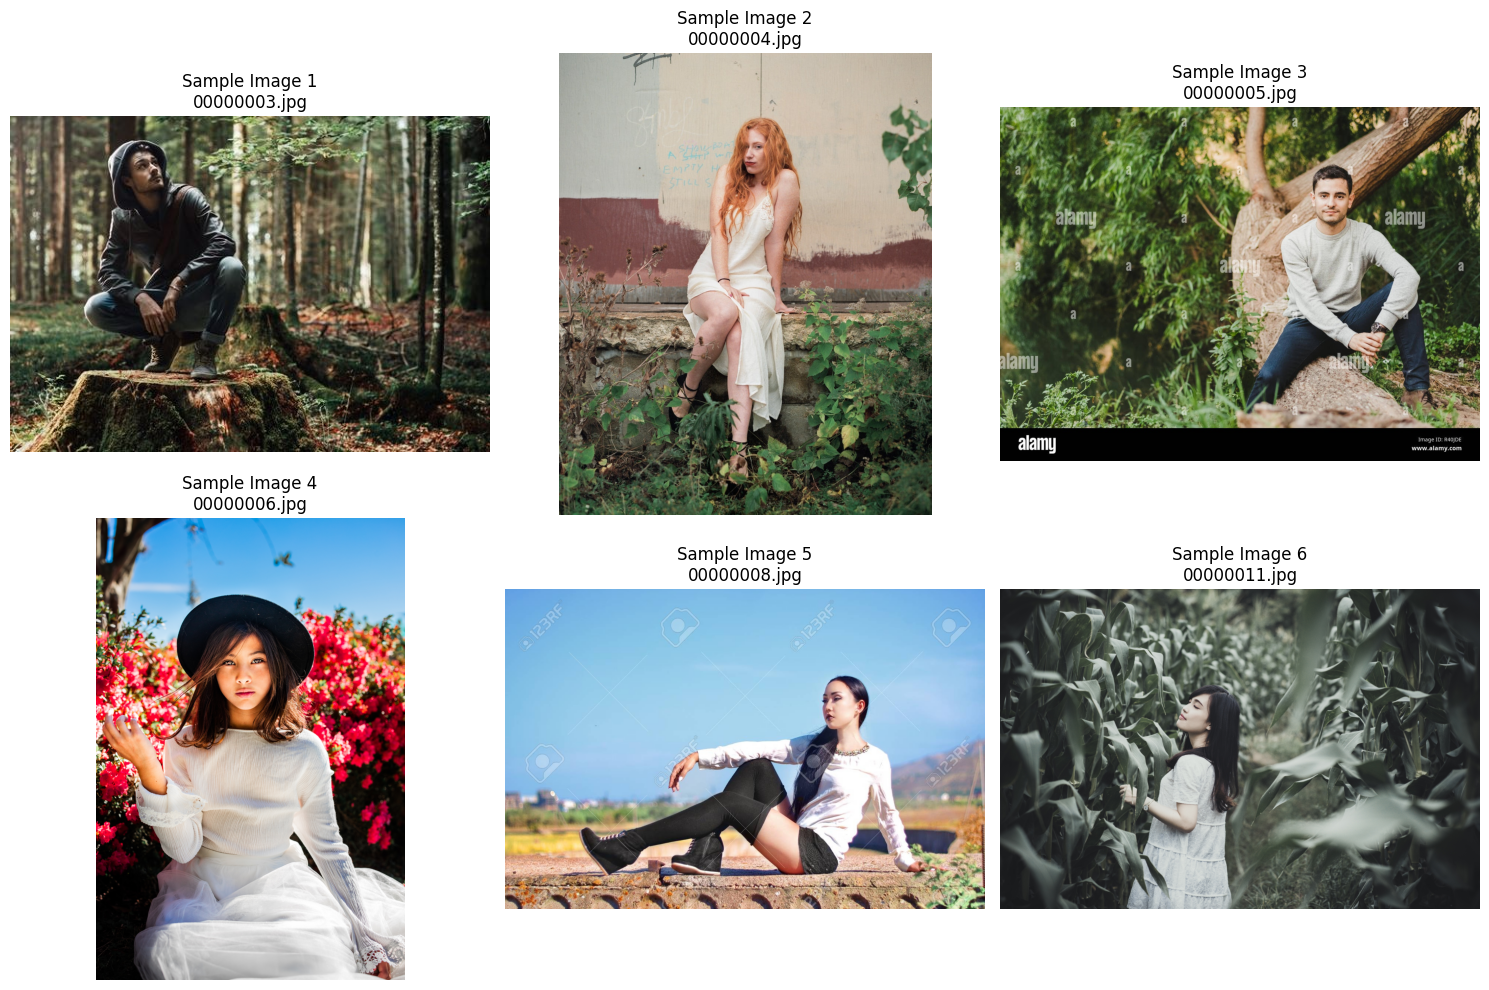

In [110]:
# Explore the face dataset - corrected version

# face_dataset is a tuple: (images_list, names_list)
face_images, face_names = face_dataset

# Print the number of images in the dataset
print(f"Number of images in the dataset: {len(face_images)}")

# Display the first 6 sample images (instead of 21 to avoid too much output)
plt.figure(figsize=(15, 10))
for i in range(min(6, len(face_images))):
    plt.subplot(2, 3, i + 1)
    plt.imshow(face_images[i])
    plt.title(f"Sample Image {i+1}\n{face_names[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# 🖼️ Image Upload and Display Examples

## Using Markdown Syntax: `![title](filename.jpeg)`

### Basic Syntax
```markdown
![Image Title](filename.jpeg)
```

### Examples with Different Image Types
```markdown
![My Photo](photo.jpg)
![Screenshot](screenshot.png)
![Diagram](diagram.gif)
```

### HTML Alternative for More Control
```html
<img src="filename.jpeg" width="400" alt="Image Title">
<img src="filename.jpeg" style="width:50%; height:auto;">
```

In [ ]:
# 📁 CREATE SAMPLE IMAGES FOR DEMONSTRATION
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def create_sample_images():
    """Create sample images to demonstrate markdown display"""
    
    print("🎨 Creating sample images for demonstration...")
    
    # Create sample image 1: Colorful geometric shapes
    img1 = np.zeros((300, 400, 3), dtype=np.uint8)
    img1[:, :] = [50, 50, 50]  # Dark gray background
    
    # Add colorful shapes
    cv2.rectangle(img1, (50, 50), (150, 150), (255, 100, 100), -1)   # Red rectangle
    cv2.circle(img1, (300, 100), 60, (100, 255, 100), -1)           # Green circle
    cv2.rectangle(img1, (100, 180), (300, 250), (100, 100, 255), -1) # Blue rectangle
    
    # Add text
    cv2.putText(img1, 'Sample Image 1', (120, 280), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Save as JPEG
    cv2.imwrite('sample_image1.jpeg', img1)
    
    # Create sample image 2: Pattern
    img2 = np.zeros((250, 350, 3), dtype=np.uint8)
    
    # Create a checkerboard pattern
    for i in range(0, 250, 50):
        for j in range(0, 350, 50):
            if (i//50 + j//50) % 2 == 0:
                img2[i:i+50, j:j+50] = [200, 150, 100]  # Light brown
            else:
                img2[i:i+50, j:j+50] = [100, 150, 200]  # Light blue
    
    # Add a border
    cv2.rectangle(img2, (10, 10), (340, 240), (255, 255, 255), 3)
    cv2.putText(img2, 'Pattern Image', (100, 130), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    
    # Save as PNG
    cv2.imwrite('pattern_image.png', img2)
    
    # Create sample image 3: Gradient
    img3 = np.zeros((200, 300, 3), dtype=np.uint8)
    
    # Create gradient effect
    for i in range(200):
        for j in range(300):
            img3[i, j] = [i, j//2, (i+j)//3]
    
    cv2.putText(img3, 'Gradient', (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Save as JPG
    cv2.imwrite('gradient.jpg', img3)
    
    print("✅ Created sample images:")
    print("   📸 sample_image1.jpeg")
    print("   📸 pattern_image.png") 
    print("   📸 gradient.jpg")
    
    return ['sample_image1.jpeg', 'pattern_image.png', 'gradient.jpg']

def display_with_matplotlib(image_files):
    """Display the created images using matplotlib"""
    
    print("\n🖼️ Displaying images with matplotlib:")
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, filename in enumerate(image_files):
        if os.path.exists(filename):
            img = cv2.imread(filename)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[i].imshow(img_rgb)
            axes[i].set_title(f'{filename}', fontweight='bold')
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f'File not found:\n{filename}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'Error: {filename}')
    
    plt.tight_layout()
    plt.show()

# Create the sample images
sample_files = create_sample_images()

# Display them with matplotlib
display_with_matplotlib(sample_files)

# 📸 Live Examples: Using ![title](filename.jpeg)

Now let's demonstrate the markdown image syntax with the images we just created:

## Example 1: Basic Image Display
![Sample Image 1](sample_image1.jpeg)

## Example 2: Pattern Image
![Pattern Image](pattern_image.png)

## Example 3: Gradient Image  
![Gradient](gradient.jpg)

---

## 🎨 Advanced HTML Examples

### Resized Images
<img src="sample_image1.jpeg" width="300" alt="Resized Sample Image">

### Centered Image with Caption
<div align="center">
    <img src="pattern_image.png" width="250">
    <br><em>Centered pattern image with custom width</em>
</div>

### Styled Images
<img src="gradient.jpg" style="width:200px; border:3px solid #ddd; border-radius:10px; margin:10px;">

### Side-by-Side Images
<table>
<tr>
<td><img src="sample_image1.jpeg" width="200"></td>
<td><img src="pattern_image.png" width="200"></td>
<td><img src="gradient.jpg" width="200"></td>
</tr>
<tr>
<td align="center"><em>Geometric Shapes</em></td>
<td align="center"><em>Pattern Design</em></td>
<td align="center"><em>Color Gradient</em></td>
</tr>
</table>

In [ ]:
# 📋 COMPLETE GUIDE: Image Upload Methods
print("📋 COMPLETE GUIDE: Image Upload and Display Methods")
print("=" * 55)

def image_upload_guide():
    """Complete guide for uploading and displaying images"""
    
    print("🔍 AVAILABLE METHODS FOR IMAGE DISPLAY:")
    print("-" * 45)
    
    print("\n1️⃣ MARKDOWN SYNTAX (Simplest)")
    print("   ![title](filename.jpeg)")
    print("   • Pros: Simple, clean syntax")
    print("   • Cons: Limited styling options")
    print("   • Best for: Quick image insertion")
    
    print("\n2️⃣ HTML IMG TAG (More Control)")
    print("   <img src='filename.jpeg' width='400' alt='title'>")
    print("   • Pros: Size control, styling, alignment")
    print("   • Cons: More verbose")
    print("   • Best for: Precise layout control")
    
    print("\n3️⃣ PYTHON/MATPLOTLIB (Programmatic)")
    print("   plt.imshow(image); plt.show()")
    print("   • Pros: Full programmatic control, annotations")
    print("   • Cons: Requires code execution")
    print("   • Best for: Analysis and processing")
    
    print("\n4️⃣ IPYTHON DISPLAY (Interactive)")
    print("   from IPython.display import Image; Image('file.jpg')")
    print("   • Pros: Native Jupyter integration")
    print("   • Cons: Requires import")
    print("   • Best for: Interactive notebooks")

def file_format_support():
    """Show supported file formats"""
    
    print("\n🎨 SUPPORTED IMAGE FORMATS:")
    print("-" * 30)
    
    formats = {
        'JPEG/JPG': 'Most common, good compression',
        'PNG': 'Supports transparency, lossless',
        'GIF': 'Animated images, limited colors', 
        'BMP': 'Uncompressed, large files',
        'TIFF': 'High quality, large files',
        'SVG': 'Vector graphics, scalable'
    }
    
    for fmt, desc in formats.items():
        print(f"   📸 {fmt}: {desc}")

def common_issues_solutions():
    """Common issues and solutions"""
    
    print("\n🔧 COMMON ISSUES & SOLUTIONS:")
    print("-" * 35)
    
    issues = [
        ("Image not displaying", "Check file path and ensure file exists"),
        ("Image too large", "Use HTML width attribute: <img src='file.jpg' width='400'>"),
        ("Wrong file format", "Convert to JPG/PNG using image editing software"),
        ("Path issues", "Use relative paths or place images in same folder"),
        ("Broken link", "Verify filename spelling and extension"),
    ]
    
    for issue, solution in issues:
        print(f"   ❌ {issue}")
        print(f"      ✅ {solution}")
        print()

def create_upload_template():
    """Create a template for users"""
    
    print("\n📝 TEMPLATE FOR YOUR IMAGES:")
    print("-" * 32)
    
    template = '''
    # Your Image Upload Section
    
    ## Method 1: Simple Markdown
    ![My Image Title](your_image.jpeg)
    
    ## Method 2: Resized with HTML
    <img src="your_image.jpeg" width="500" alt="My Image">
    
    ## Method 3: Centered with Caption
    <div align="center">
        <img src="your_image.jpeg" width="400">
        <br><em>Your image caption here</em>
    </div>
    '''
    
    print(template)

# Run all guides
image_upload_guide()
file_format_support()
common_issues_solutions()
create_upload_template()

print("\n🎉 You're ready to upload images using ![title](filename.jpeg)!")
print("💡 Remember: Place your image files in the same folder as this notebook")

In [ ]:
#b- Download required tools
# Install the required packages.
import os
HOME = os.getcwd()
!pip install -q git+https://github.com/THU-MIG/yolov10.git

In [ ]:
# Load pretrained weights
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

In [ ]:
#c- Test the model out of box

In [ ]:
#d- Fine-tune the model
# Show the learning curve and confusion matrix

In [ ]:
# e- SExplain what you see in the learning curves and confusion matrix.